**Importing necessary liraries**

In [1]:
import tensorflow as tf
import os
import random
import numpy as np
from tqdm import tqdm 
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)
# root_path = '/content/drive/MyDrive/nuclie/stage1_train'
# root_path

Mounted at /content/gdrive/


In [3]:
seed = 30
np.random.seed = seed

**Pre-processing the data** 
> Resizing images and masks



In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_channel = 3

train_path = '/content/gdrive/MyDrive/nuclie/stage1_train/'
test_path = '/content/gdrive/MyDrive/nuclie/stage1_test/'

train_ids = next(os.walk(train_path))[1]
test_ids  = next(os.walk(test_path))[1]

X_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,IMG_channel),dtype=np.uint8)
Y_train = np.zeros((len(train_ids),IMG_HEIGHT,IMG_WIDTH,1),dtype=np.bool)
print('Resizing training images and masks')
for n,id_ in tqdm(enumerate(train_ids),total=len(train_ids)):
  path = train_path + id_
  img = imread(path+'/images/'+id_+'.png')[:,:,:IMG_channel]
  img = resize(img, (IMG_HEIGHT,IMG_WIDTH, 1), mode='constant',preserve_range=True)
  X_train[n] = img   
  mask = np.zeros((IMG_HEIGHT,IMG_WIDTH, 1), dtype=np.bool)
  for mask_file in next(os.walk(path+'/masks/'))[2]:
    mask_ = imread(path+'/masks/'+mask_file)
    mask_ = np.expand_dims(resize(mask_,(IMG_HEIGHT,IMG_WIDTH),mode='constant',preserve_range=True),axis=-1)
    mask = np.maximum(mask,mask_)

  Y_train[n] = mask






  0%|          | 0/669 [00:00<?, ?it/s]

Resizing training images and masks


100%|██████████| 669/669 [1:40:03<00:00,  8.97s/it]


  0%|          | 0/63 [00:00<?, ?it/s]

Resizing test images


100%|██████████| 63/63 [00:26<00:00,  2.37it/s]


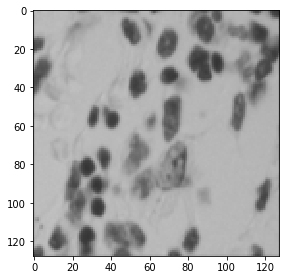

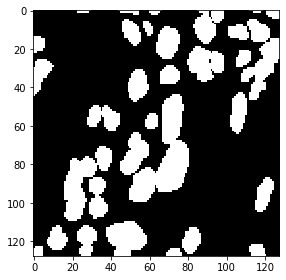

In [5]:
# test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_channel), dtype=np.uint8)
sizes_test = []
print('Resizing test images') 
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = test_path + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_channel]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img



image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


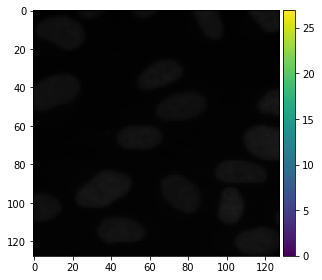

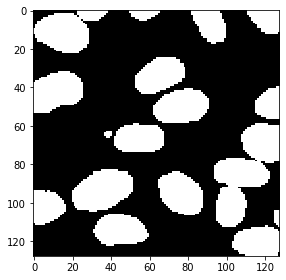

In [6]:
image_x = random.randint(0, len(train_ids))
imshow(X_train[image_x])
plt.show()
imshow(np.squeeze(Y_train[image_x]))
plt.show()

##Building the model

In [7]:
inputs = tf.keras.layers.Input((IMG_WIDTH,IMG_HEIGHT,IMG_channel))

s = tf.keras.layers.Lambda(lambda x:x / 255)(inputs)

#encoder
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3),activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#decoder
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)


outputs = tf.keras.layers.Conv2D(1,(1,1), activation='sigmoid')(c9)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

**model checkpoints**

In [8]:
checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclie.h5',verbose=1,save_best_only='true')


callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
             tf.keras.callbacks.TensorBoard(log_dir='logs')]

results = model.fit(X_train,Y_train, validation_split=0.1,batch_size=16, epochs=25, callbacks=callbacks)             

Epoch 1/25
38/38 [==============================] - 103s 3s/step - loss: 0.6408 - accuracy: 0.7282 - val_loss: 0.4086 - val_accuracy: 0.8133
Epoch 2/25
38/38 [==============================] - 100s 3s/step - loss: 0.3585 - accuracy: 0.8223 - val_loss: 0.1902 - val_accuracy: 0.9179
Epoch 3/25
38/38 [==============================] - 99s 3s/step - loss: 0.2053 - accuracy: 0.9171 - val_loss: 0.1416 - val_accuracy: 0.9409
Epoch 4/25
38/38 [==============================] - 99s 3s/step - loss: 0.1645 - accuracy: 0.9328 - val_loss: 0.1296 - val_accuracy: 0.9456
Epoch 5/25
38/38 [==============================] - 100s 3s/step - loss: 0.1450 - accuracy: 0.9419 - val_loss: 0.1447 - val_accuracy: 0.9421
Epoch 6/25
38/38 [==============================] - 100s 3s/step - loss: 0.1495 - accuracy: 0.9398 - val_loss: 0.1103 - val_accuracy: 0.9560
Epoch 7/25
38/38 [==============================] - 100s 3s/step - loss: 0.1187 - accuracy: 0.9528 - val_loss: 0.1172 - val_accuracy: 0.9544
Epoch 8/25
38/3

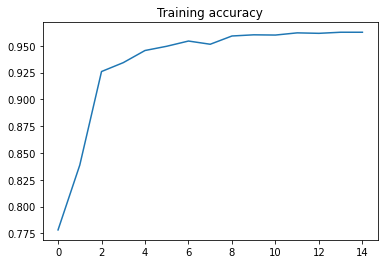

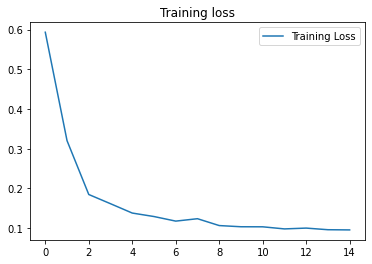

In [9]:
acc = results.history['accuracy']
loss = results.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, label='Training accuracy')
plt.title('Training accuracy')
plt.figure()
plt.plot(epochs, loss,label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [10]:
idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

2/2 [==============================] - 2s 1s/step


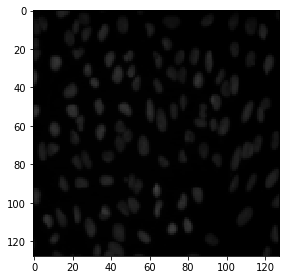

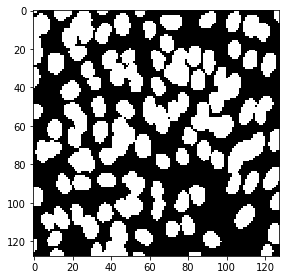

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


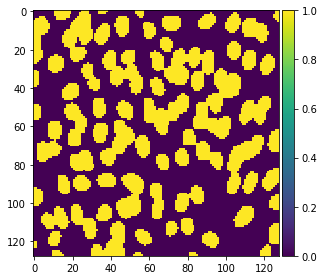

In [11]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()